In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAE
from schedulers import DDPM
from schedulers import DDIMSampler
from vae import VAE
from schedulers import DDIMSampler, DDPMSampler
from fid import FIDScore


fid_calculator = FIDScore()



mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vae_model = VAE(latent_dim=64)
vae_model.load_state_dict(torch.load('vae_model2.pth'))
vae_model.eval()

for param in vae_model.parameters():
    param.requires_grad = False

unet = UNetTimedWithVAE(vae_model, )


/tmp/ipykernel_34656/2616152254.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('vae_model2.pth'))


In [3]:
# Create DataLoader
batch_size = 128
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer and loss function
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-5)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)

# DDPM instance
ddpm = DDPMSampler()
fid_history = []
loss_history = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        
        latent_images = unet.encode_vae(images)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Generate random noise
        noise = torch.randn_like(latent_images).to(device)
        
        # Generate random timesteps
        batch_size = latent_images.shape[0]
        timesteps = torch.randint(0, ddpm.max_timestep, (batch_size,), device=device)
        
        # Add noise to images according to timesteps
        noised_images = ddpm.add_noise(latent_images, timesteps, noise)
        
        # Predict noise
        predicted_noise = unet(noised_images, timesteps)
        
        # Calculate loss
        loss = mse_loss(predicted_noise, noise)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')

    # Generate samples using DDPM 
    with torch.no_grad():
        sample_images = ddpm.sample(
            model=unet.eval(),
            n_samples=batch_size, 
            img_size=(1, 8, 8),  # For MNIST
            device=device,
            steps=1000  
        )
        sample_images = unet.decode_vae(sample_images).cpu()


    # Get a batch of real images for FID calculation
    real_images = next(iter(dataloader))[0]
    real_images = real_images.to(device)

    # Compute FID score
    assert real_images.shape == sample_images.shape, f"Wrong shapes real = {real_images.shape}, sampled = {sample_images.shape}"
    fid_score = fid_calculator.calculate_fid(real_images.cpu(), sample_images.cpu())
    fid_history.append(fid_score)  # Store FID history
    print(f'Epoch {epoch} | FID Score: {fid_score:.4f}')
    
    # Optional: Save checkpoint
    # if (epoch + 1) % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': unet.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': avg_loss,
    #     }, f'latent_ddpm_checkpoint_epoch_{epoch+1}.pt')

Epoch 0 | Batch 0 | Loss: 1.0744
Epoch 0 | Batch 100 | Loss: 0.5702
Epoch 0 | Batch 200 | Loss: 0.3411
Epoch 0 | Batch 300 | Loss: 0.3171
Epoch 0 | Batch 400 | Loss: 0.2581
Epoch 0 | Average Loss: 0.4342
Epoch 0 | FID Score: 23730.8644
Epoch 1 | Batch 0 | Loss: 0.2236
Epoch 1 | Batch 100 | Loss: 0.2487
Epoch 1 | Batch 200 | Loss: 0.2791
Epoch 1 | Batch 300 | Loss: 0.2568
Epoch 1 | Batch 400 | Loss: 0.2758
Epoch 1 | Average Loss: 0.2538
Epoch 1 | FID Score: 1457.6254
Epoch 2 | Batch 0 | Loss: 0.1946
Epoch 2 | Batch 100 | Loss: 0.2711
Epoch 2 | Batch 200 | Loss: 0.2210
Epoch 2 | Batch 300 | Loss: 0.2188
Epoch 2 | Batch 400 | Loss: 0.2803
Epoch 2 | Average Loss: 0.2369
Epoch 2 | FID Score: 40.3051
Epoch 3 | Batch 0 | Loss: 0.2108
Epoch 3 | Batch 100 | Loss: 0.2167
Epoch 3 | Batch 200 | Loss: 0.1939
Epoch 3 | Batch 300 | Loss: 0.2650
Epoch 3 | Batch 400 | Loss: 0.2438
Epoch 3 | Average Loss: 0.2300
Epoch 3 | FID Score: 39.0036
Epoch 4 | Batch 0 | Loss: 0.2523
Epoch 4 | Batch 100 | Loss: 0.

KeyboardInterrupt: 

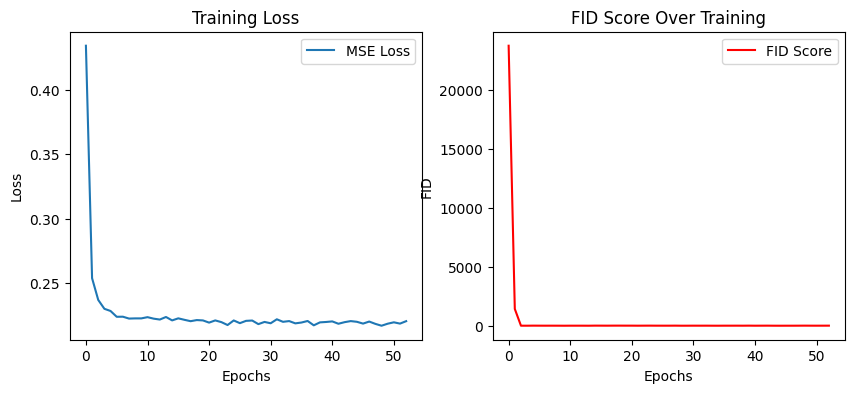

In [4]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_history, label="FID Score", color='r')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("FID Score Over Training")
plt.legend()

plt.show()

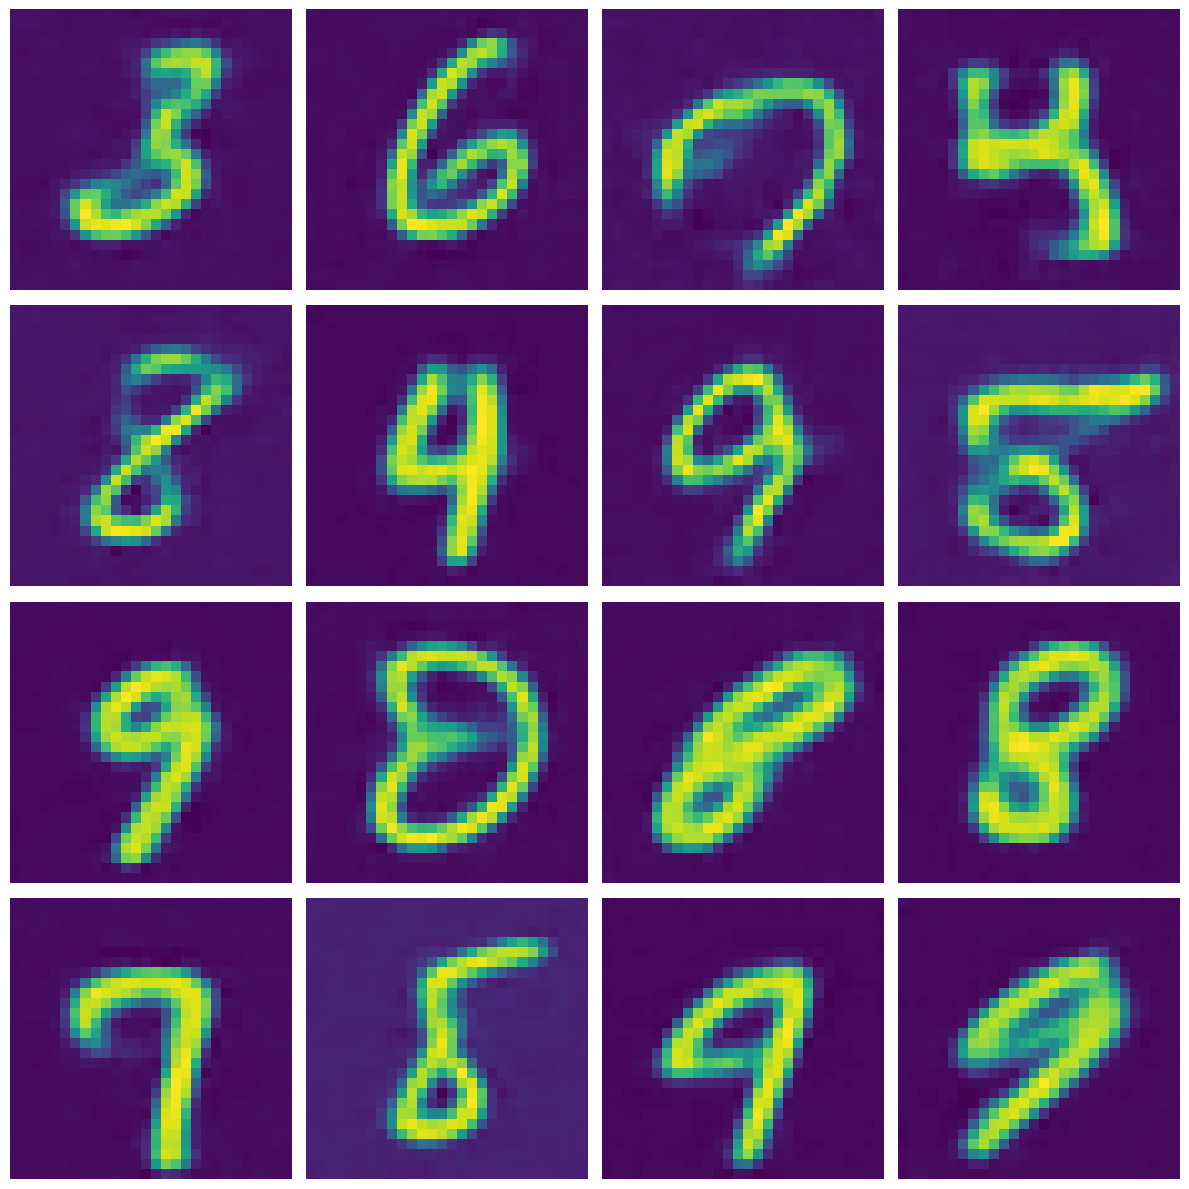

In [19]:
sampled_latent_images = ddpm.sample(
    model=unet,
    n_samples=16,
    img_size=(1, 8, 8),  # For MNIST
    device=device,
    steps=10 # Can use fewer steps than training
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = unet.decode_vae(sampled_latent_images[i]).cpu().numpy()[0,0]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

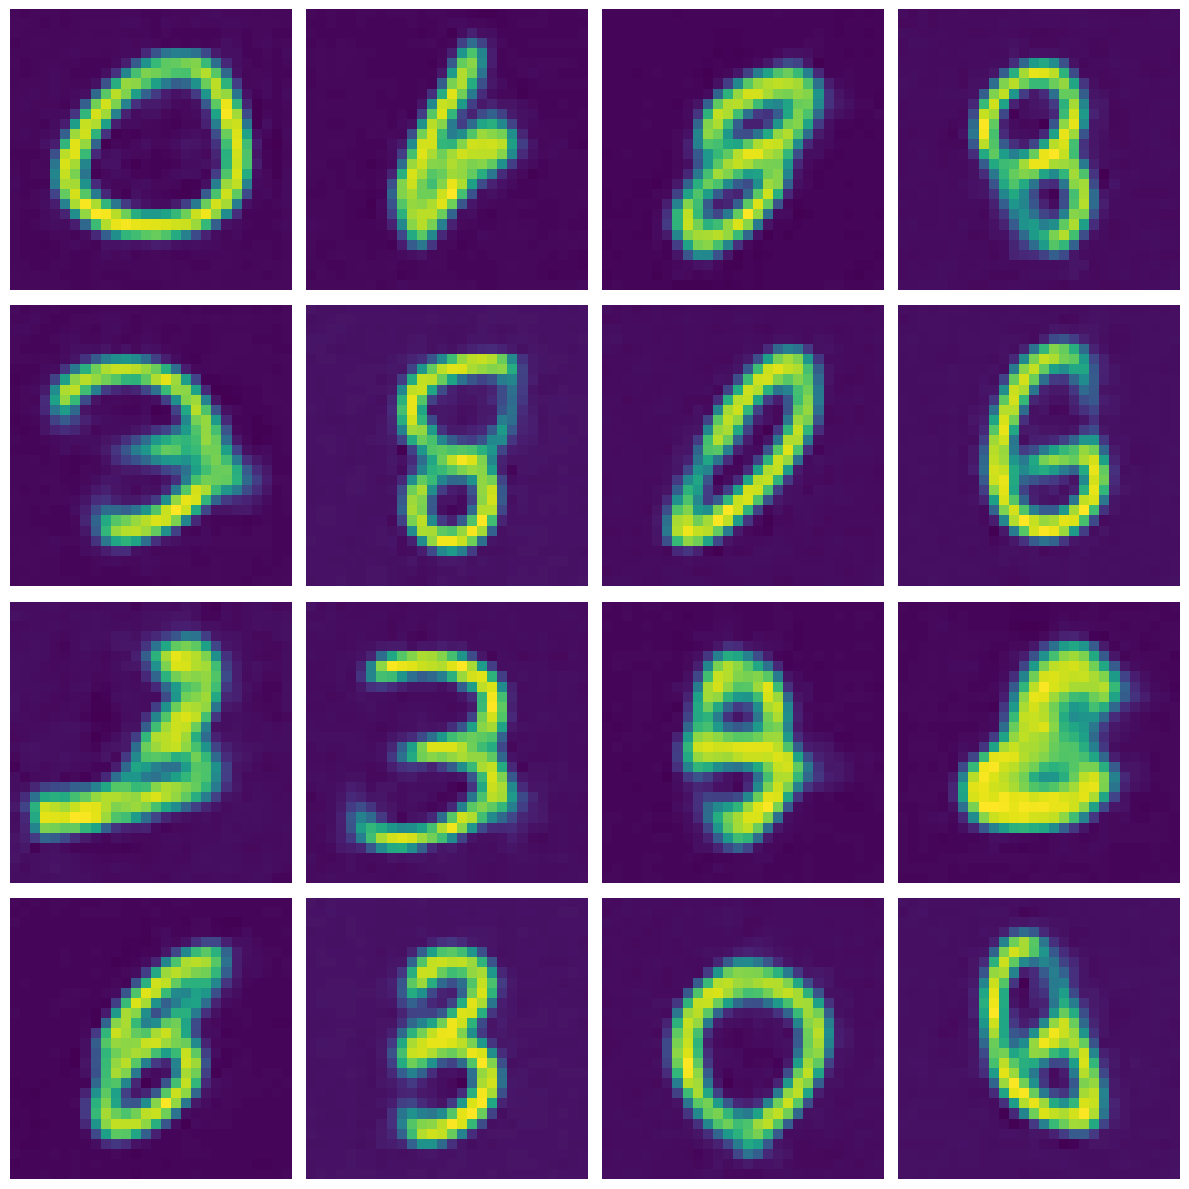

In [16]:
ddim = DDIMSampler()

sampled_latent_images = ddim.sample(
    model=unet,
    n_samples=16,
    img_size=(1, 8, 8),  # For MNIST
    device=device,
    steps=10, # Can use fewer steps than training
    eta = 0.3
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = unet.decode_vae(sampled_latent_images[i]).cpu().numpy()[0,0]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Compare inference from DDPM and DDIM

Sampler: DDIM eta=0, Steps: 1, FID Score: 39.8396
Sampler: DDIM eta=0, Steps: 5, FID Score: 40.6511
Sampler: DDIM eta=0, Steps: 10, FID Score: 41.8551
Sampler: DDIM eta=0, Steps: 25, FID Score: 38.4781
Sampler: DDIM eta=0, Steps: 50, FID Score: 39.6349
Sampler: DDIM eta=0, Steps: 100, FID Score: 41.3540
Sampler: DDIM eta=0.3, Steps: 1, FID Score: 41.8885
Sampler: DDIM eta=0.3, Steps: 5, FID Score: 42.2125
Sampler: DDIM eta=0.3, Steps: 10, FID Score: 43.8870
Sampler: DDIM eta=0.3, Steps: 25, FID Score: 40.9708
Sampler: DDIM eta=0.3, Steps: 50, FID Score: 40.0509
Sampler: DDIM eta=0.3, Steps: 100, FID Score: 40.5018
Sampler: DDPM, Steps: 1, FID Score: 41.3733
Sampler: DDPM, Steps: 5, FID Score: 41.9989
Sampler: DDPM, Steps: 10, FID Score: 38.3927
Sampler: DDPM, Steps: 25, FID Score: 44.9428
Sampler: DDPM, Steps: 50, FID Score: 41.4890
Sampler: DDPM, Steps: 100, FID Score: 40.2537


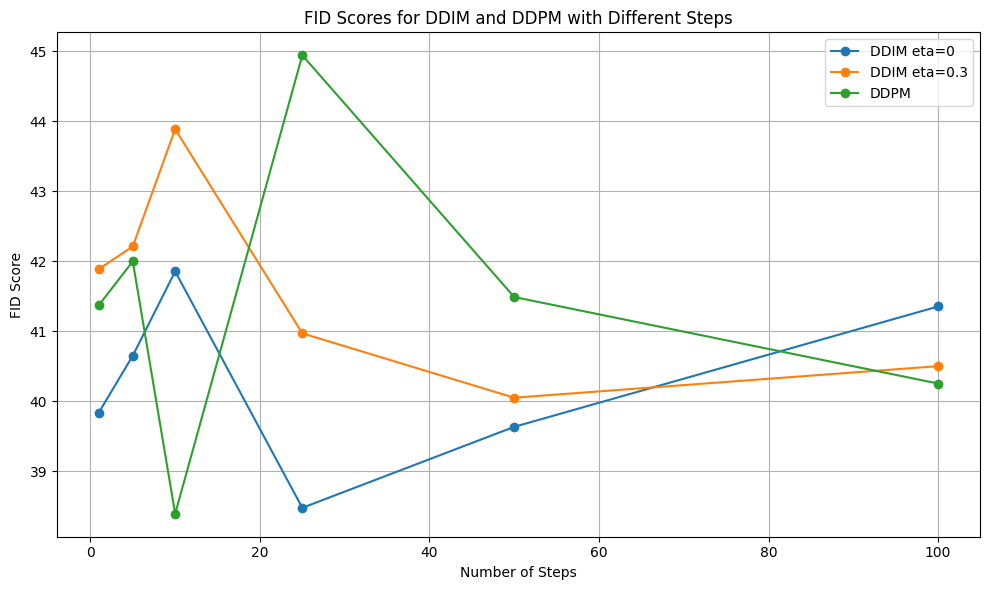

In [22]:
import matplotlib.pyplot as plt

# Set batch size
batch_size = 128  

# Predefined real images for FID calculation
real_images = next(iter(dataloader))[0]
real_images = real_images.to(device)

# Step sizes and eta values for DDIM and DDPM
steps_list = [1, 5, 10, 25, 50, 100]
etas = [0, 0.3]  # DDIM eta values
samplers = {
    "DDIM eta=0": (DDIMSampler(), 0),
    "DDIM eta=0.3": (DDIMSampler(), 0.3),
    "DDPM": (ddpm, None),
}

# To store FID scores for plotting
fid_scores = {
    "DDIM eta=0": [],
    "DDIM eta=0.3": [],
    "DDPM": [],
}

# Loop over the samplers and steps
for sampler_name, (sampler, eta) in samplers.items():
    for steps in steps_list:
        # Sample images using the given sampler, eta, and step size
        if eta is not None:
            sampled_latent_images = sampler.sample(
                model=unet.eval(),
                n_samples=batch_size,
                img_size=(1, 8, 8),  # For MNIST
                device=device,
                steps=steps,
                eta=eta if eta is not None else 0,  # Use eta only for DDIM
            )
        if eta is None:
            sampled_latent_images = sampler.sample(
                model=unet.eval(),
                n_samples=batch_size,
                img_size=(1, 8, 8),  # For MNIST
                device=device,
                steps=steps,
            )
        # Decode the sampled latent images
        decoded_images = unet.decode_vae(sampled_latent_images).cpu()

        # Compute FID score
        assert real_images.shape == decoded_images.shape, f"Shape mismatch: real = {real_images.shape}, sampled = {decoded_images.shape}"
        fid_score = fid_calculator.calculate_fid(real_images.cpu(), decoded_images.cpu())
        fid_scores[sampler_name].append(fid_score)
        print(f"Sampler: {sampler_name}, Steps: {steps}, FID Score: {fid_score:.4f}")

# Plot FID scores for all samplers
plt.figure(figsize=(10, 6))
for sampler_name, scores in fid_scores.items():
    plt.plot(steps_list, scores, label=sampler_name, marker='o')

plt.title('FID Scores for DDIM and DDPM with Different Steps')
plt.xlabel('Number of Steps')
plt.ylabel('FID Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
